# Introduction

This analysis will look at frequency spectra of time series of the 10 outputs by the IMU sensors.  Each time series (128 units of time) will be converted into frequency domain using numpy fft functions.  These frequency spectra will be used as features (instead of the time series).

Random Rain Forest is the only model used to predict. 

In [8]:
# Importing the libraries
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [9]:
# Importing the dataset
X = pd.read_csv('./X_train.csv')
# X_test=pd.read_csv('.X_test.csv')
target=pd.read_csv('./y_train.csv')
# y=pd.read_csv('../input/sample_submission.csv')
target['surface'].head()

0    fine_concrete
1         concrete
2         concrete
3         concrete
4       soft_tiles
Name: surface, dtype: object

In [10]:
# Get a list of unique surface types
surfaces_list=target['surface'].unique()

In [12]:
seriesID_list=X['series_id'].unique()

In [14]:
# Define a list of column names to store fft data
fft_names_list=['offt_X','offt_Y','offt_Z','offt_W','afft_X','afft_Y','afft_Z','lfft_X','lfft_Y','lfft_Z']
# Prefix offt, afft, and lfft are assgined as the names for fft data of orientation, angular_velocity, and linear_acceleration, respectively

In [8]:
# Scaling train and test sets
pre_scaler = StandardScaler()
X_prescaled = pd.DataFrame(pre_scaler.fit_transform(X.loc[:,X.columns[3:]]),columns=X.columns[3:])
# X_test_prescaled= pd.DataFrame(pre_scaler.transform(X_test.loc[:,X_test.columns[3:]]),columns=X_test.columns[3:])

In [9]:
X_prescaled     =X[X.columns[0:3]].merge(X_prescaled,left_index=True,right_index=True)
# X_test_prescaled=X_test[X_test.columns[0:3]].merge(X_test_prescaled,left_index=True,right_index=True)
# X_test_prescaled.head()

In [10]:
def fft_calculate(X):
# Calculate FFT data for each series (Each series consists of 128 units of time)
# Each series has 10 parameters (orientation_X,...,angular_velocity_X,....,linear_acceleration_X,...)
# Each of the parameters will be fourier transformed using numpy fft function
    fft_data={}
    fft_names_list=['offt_X','offt_Y','offt_Z','offt_W','afft_X','afft_Y','afft_Z','lfft_X','lfft_Y','lfft_Z']
    for seriesID in range(round(len(X)/128)):
        fft_data[seriesID]={}
        i=-1
        for col in X.columns[3:]:   #stepping through each parameter columns
            c=np.fft.rfft(X[X['series_id']==seriesID][col])  # Calculate real fft
            x=np.real(np.abs(c))  # Calculate the amplitude of fft
            i+=1
            fft_name=fft_names_list[i]  # Assign names for fft data (orientation_X-->offt_X, etc.)
            fft_data[seriesID][fft_name]=x
    return fft_data

In [12]:
# Calculate FFT data for train and test sets

fft_data=fft_calculate(X_prescaled)
# fft_test_data=fft_calculate(X_test_prescaled)

In [10]:
# Group series_id's into their respective surface types
seriesID_group={}
for floor_type in surfaces_list:
    seriesID_group[floor_type]=target[target['surface']==floor_type].series_id

# Plotting for data exploration

In [11]:
#Calculate fft average for each parameter_X,Y,Z for each surface.  
#These average values are for viewing only, not used for training.
fft_average={}
for floor_type in surfaces_list:
    count=len(seriesID_group[floor_type])
    fft_average[floor_type]={}
    cumsum={}
    for fft in fft_names_list:
        cumsum[fft]=np.zeros(65)
        for seriesID in seriesID_group[floor_type]:
            cumsum[fft]+=fft_data[seriesID][fft]
        fft_average[floor_type][fft]=np.zeros(65)
        fft_average[floor_type][fft]=cumsum[fft]/count                

In [12]:
# Preview of fft spectra
plt.figure(figsize=(26, 26))
i=0
for fft in fft_names_list:
    i+=1
    if i==8:
        i+=1
    plt.subplot(3,4,i)
    if fft in ['offt_X','offt_Y','offt_Z','offt_W']:
        plt.ylim(0,0.4)
    plt.title(fft, fontsize=20)
#    plt.yscale('log')
    for floor_type in surfaces_list:
        plt.plot(fft_average[floor_type][fft][:])
    plt.legend(surfaces_list)

# Feature engineering

In [21]:
len(fft_data)

3810

In [22]:
def fft_stats(fft_data):
# Calculate the mean, sum, and standard deviation of spectra 
    df_fft=pd.DataFrame()
    for fft in fft_names_list:
            sum_=fft+'_sum'
            mean=fft+'_mean'
            std=fft+'_std'
            for seriesID in range(len(fft_data)):
                    df_fft.loc[seriesID,sum_]=np.sum(fft_data[seriesID][fft])
                    df_fft.loc[seriesID,mean]=np.mean(fft_data[seriesID][fft])
                    df_fft.loc[seriesID,std]=np.std(fft_data[seriesID][fft])
    return df_fft

In [23]:
df_fft=fft_stats(fft_data)
# df_fft_test=fft_stats(fft_test_data)

In [25]:
df_fft

offt_X_sum  offt_X_mean  offt_X_std  offt_Y_sum  offt_Y_mean  \
0     138.411875     2.129413   17.015342  128.354633     1.974687   
1     175.641478     2.702177   21.609155   30.394924     0.467614   
2      92.939858     1.429844   11.348448  166.902564     2.567732   
3     172.041805     2.646797   21.162528   42.713170     0.657126   
4     164.526126     2.531171   20.060062   66.854904     1.028537   
...          ...          ...         ...         ...          ...   
3805   39.857107     0.613186    4.840717  160.375819     2.467320   
3806  105.203384     1.618514   12.871995  136.212221     2.095573   
3807   81.949549     1.260762    9.142543  151.572043     2.331878   
3808   48.204868     0.741613    5.660261  159.209130     2.449371   
3809  120.745005     1.857615   14.839864  152.797737     2.350734   

      offt_Y_std  offt_Z_sum  offt_Z_mean  offt_Z_std  offt_W_sum  ...  \
0      15.772233  143.353244     2.205435   17.530087  127.102902  ...   
1       3.709957   24.666889     0.379491    2.850741  177.118303  ...   
2      20.491226  172.668360     2.656436   21.081691   83.549457  ...   
3       5.228671   33.006995     0.507800    3.937432  172.752054  ...   
4       7.848612   60.748163     0.934587    7.070375  163.909967  ...   
...          ...         ...          ...         ...         ...  ...   
3805   19.722903  161.359143     2.482448   19.654596   48.520086  ...   
3806   16.716340  142.285122     2.189002   17.456682   98.999727  ...   
3807   18.240972  161.509640     2.484764   18.974959   86.150549  ...   
3808   19.521916  159.038106     2.446740   19.262488   54.185350  ...   
3809   18.788497  117.674819     1.810382   14.317223  104.261161  ...   

      afft_Z_std  lfft_X_sum  lfft_X_mean  lfft_X_std   lfft_Y_sum  \
0       1.911020  208.101388     3.201560    4.551770   210.553031   
1       3.438063  339.173735     5.218057    4.077873   352.890366   
2       3.288737  210.733768     3.242058    3.156317   296.042565   
3       2.183239  436.493436     6.715284    5.720067   652.301794   
4       8.572508  110.328803     1.697366    2.703601   149.786263   
...          ...         ...          ...         ...          ...   
3805    2.345485  528.359219     8.128603    8.831259   479.566722   
3806    1.278774    7.469435     0.114914    0.170451     6.131051   
3807   22.155936  842.756969    12.965492   14.997013  1136.168825   
3808    8.029539  640.708490     9.857054   11.892794   602.867188   
3809    2.888352  305.839748     4.705227    7.027297   318.399927   

      lfft_Y_mean  lfft_Y_std  lfft_Z_sum  lfft_Z_mean  lfft_Z_std  
0        3.239277    6.528539  193.882079     2.982801    3.112246  
1        5.429083    8.141335  358.530355     5.515852    6.262698  
2        4.554501    8.048390  213.244111     3.280679    3.057722  
3       10.035412   19.599177  558.336689     8.589795   10.646387  
4        2.304404    5.525958  126.019010     1.938754    2.539218  
...           ...         ...         ...          ...         ...  
3805     7.377950    5.827256  654.512578    10.069424   14.163133  
3806     0.094324    0.152862    3.759598     0.057840    0.047775  
3807    17.479520   17.484220  935.049902    14.385383   16.120517  
3808     9.274880   18.195620  527.884916     8.121306    9.387676  
3809     4.898460   10.558467  180.181233     2.772019    3.095126  

[3810 rows x 30 columns]

# Construct Dataframe for training

In [27]:
# Make a copy of fft dataframe
df=df_fft.copy()
df=df.reset_index(drop=True)
# df_test=df_fft_test.copy()
# df_test=df_test.reset_index(drop=True)

In [28]:
df=target.merge(df,left_index=True,right_index=True)
df.head()

series_id  group_id        surface  offt_X_sum  offt_X_mean  offt_X_std  \
0          0        13  fine_concrete  138.411875     2.129413   17.015342   
1          1        31       concrete  175.641478     2.702177   21.609155   
2          2        20       concrete   92.939858     1.429844   11.348448   
3          3        31       concrete  172.041805     2.646797   21.162528   
4          4        22     soft_tiles  164.526126     2.531171   20.060062   

   offt_Y_sum  offt_Y_mean  offt_Y_std  offt_Z_sum  ...  afft_Z_std  \
0  128.354633     1.974687   15.772233  143.353244  ...    1.911020   
1   30.394924     0.467614    3.709957   24.666889  ...    3.438063   
2  166.902564     2.567732   20.491226  172.668360  ...    3.288737   
3   42.713170     0.657126    5.228671   33.006995  ...    2.183239   
4   66.854904     1.028537    7.848612   60.748163  ...    8.572508   

   lfft_X_sum  lfft_X_mean  lfft_X_std  lfft_Y_sum  lfft_Y_mean  lfft_Y_std  \
0  208.101388     3.201560    4.551770  210.553031     3.239277    6.528539   
1  339.173735     5.218057    4.077873  352.890366     5.429083    8.141335   
2  210.733768     3.242058    3.156317  296.042565     4.554501    8.048390   
3  436.493436     6.715284    5.720067  652.301794    10.035412   19.599177   
4  110.328803     1.697366    2.703601  149.786263     2.304404    5.525958   

   lfft_Z_sum  lfft_Z_mean  lfft_Z_std  
0  193.882079     2.982801    3.112246  
1  358.530355     5.515852    6.262698  
2  213.244111     3.280679    3.057722  
3  558.336689     8.589795   10.646387  
4  126.019010     1.938754    2.539218  

[5 rows x 33 columns]

In [18]:
le = LabelEncoder()
df['surface'] = le.fit_transform(df['surface'])

In [19]:
#Split train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.drop(['surface','group_id','series_id'],axis=1), df['surface'], test_size = 0.2, random_state = 10)

# Training and predict

In [34]:
# List of features
df.to_csv('./fft_train.csv', index=False) 

In [30]:
df.columns.shape

(33,)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
clf=RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=0)

In [22]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val),columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

In [23]:
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
y_val_predict = clf.predict(X_val_scaled)
y_test_pred = clf.predict(X_test_scaled)

In [25]:
#Result from including full set
from sklearn.metrics import confusion_matrix, accuracy_score
print(round(accuracy_score(y_val, y_val_predict),3))

0.841


In [26]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_scaled.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

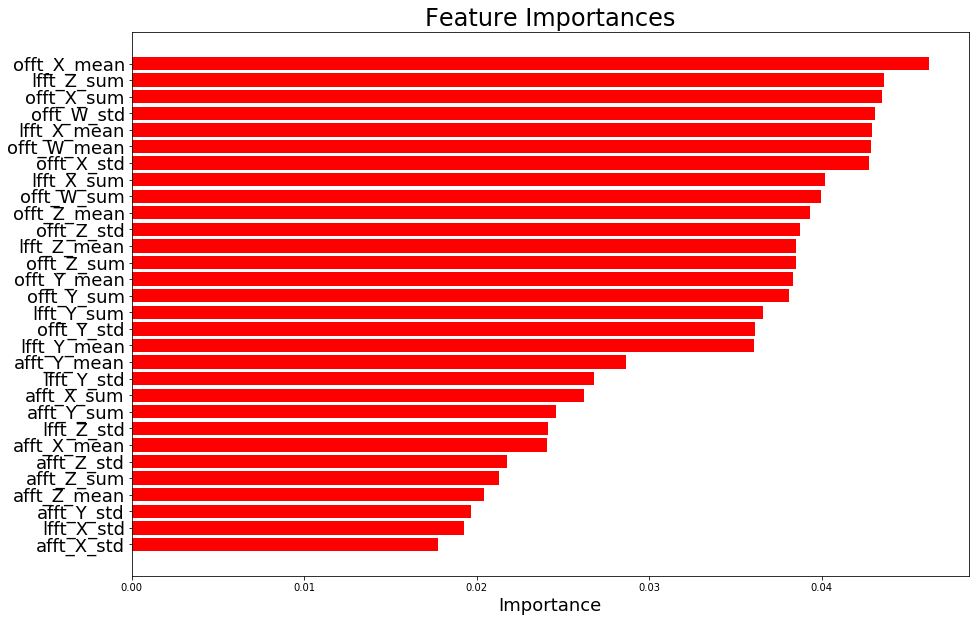

In [27]:
features = X_train_scaled.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15, 10))
plt.title('Feature Importances', fontsize=24)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), features[indices], fontsize=18)
plt.xlabel('Importance', fontsize=18)
plt.show()

In [28]:
confusion_matrix(y_val,y_val_predict)

array([[ 24,   5,   1,   0,   1,   1,   1,   2,   3],
       [  0, 129,   0,   0,   0,   8,   2,   2,   6],
       [  1,   2,  62,   0,   0,   3,   1,   1,   7],
       [  0,   0,   0,   1,   0,   1,   0,   0,   5],
       [  2,   6,   0,   0,  44,   0,   0,   0,   1],
       [  0,   7,   0,   0,   0, 144,   6,   1,  12],
       [  4,   2,   0,   0,   0,   1,  54,   0,   2],
       [  0,   3,   1,   0,   2,   1,   0,  92,   3],
       [  0,   6,   3,   0,   0,   2,   0,   3,  91]])

# Run cross validation for 10 folds

In [29]:
X_train=df.drop(['surface','group_id','series_id'],axis=1)
y_train=df['surface']

In [30]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))

In [31]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(clf, X_train_scaled, y_train, cv=10, scoring="accuracy")
print(np.around(score,3))
print('The average score is: ',round(score.mean(),3))

[0.748 0.836 0.755 0.885 0.871 0.869 0.858 0.863 0.86  0.864]
The average score is:  0.841


# Create Submission data 

In [32]:
y_test_pred=le.inverse_transform(y_test_pred)
y_test_pred[0:10]

array(['hard_tiles_large_space', 'carpet', 'tiled', 'soft_tiles',
       'soft_tiles', 'concrete', 'soft_pvc', 'hard_tiles_large_space',
       'wood', 'soft_pvc'], dtype=object)

In [33]:
y.head()

series_id   surface
0          0  concrete
1          1  concrete
2          2  concrete
3          3  concrete
4          4  concrete

In [34]:
y['surface']=y_test_pred

In [35]:
y.head(10)

series_id                 surface
0          0  hard_tiles_large_space
1          1                  carpet
2          2                   tiled
3          3              soft_tiles
4          4              soft_tiles
5          5                concrete
6          6                soft_pvc
7          7  hard_tiles_large_space
8          8                    wood
9          9                soft_pvc

In [36]:
y.to_csv('/sample_submission.csv',index=False)